In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
import scanpy as sc
import anndata as an
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from importlib import reload

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

import sys
sys.path.append('../../Hypergraph-MT/code/HyMT')
sys.path.append('../../Hypergraph-MT/code/')
import HyMT as hymt

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import plotting as plt2

# Load marker genes

In [2]:
def load_pathway(fpath):
    """
    Loads an Enrichr-like database file into a boolean DataFrame.

    Args:
        fpath (str): Path to the Enrichr-like database file.

    Returns:
        pandas.DataFrame: A boolean DataFrame where:
            - Index: Genes
            - Columns: Pathways
            - Values: True if the gene is in the pathway, False otherwise.
    """

    result = []
    with open(fpath,  encoding='utf-8') as f:
        for line in f:
            split_line = [x for x in line.strip().split('\t') if x]  # Remove empty strings directly

            row = {'label': split_line[0]}
            for gene in split_line[1:]:
                row[gene] = 1

            result.append(row)

    df = pd.DataFrame(result)
    df = df.fillna(0.0).set_index('label').astype(bool).T  # Chained operations for clarity

    return df

fpath = "../../ONT-single-cell/resources/PanglaoDB_Augmented_2021.txt"
pdf = load_pathway(fpath)
stem_genes = list(pdf[pdf['Embryonic Stem Cells']].index)
stem_genes = [x.title() for x in stem_genes]
stem_genes[:10]

['Gjb1',
 'Amotl2',
 'Yap1',
 'Fbln1',
 'Uaca',
 'Antxr1',
 'Fermt2',
 'Serpinh1',
 'Pls3',
 'Gpx8']

# Load gene data

In [3]:
# load the node centralities
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/core_of_core/node_centralities.parquet"
nodes = pd.read_parquet(fpath)
print(f"{nodes.shape}")

core_threshold_quantile = 0.75
threshold = np.quantile(nodes['norm_score'].fillna(0.0), core_threshold_quantile)
nodes['is_core'] = nodes['norm_score'].fillna(0.0) > threshold
print(nodes['is_core'].value_counts())

# map in the umap coords
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/UMAP/population_mESC_100000_UMAP.csv"
umap = pd.read_csv(fpath)
print(f"(raw) {umap.shape=}")
umap = umap[umap['n_genes'] > 0]
umap['genes'] = umap['genes'].apply(lambda x: x.split(";"))

umap = umap.explode('genes')
print(f"(exploded) {umap.shape=}")
umap = umap[umap['genes'].isin(nodes['gene_name'])]
umap = umap.rename(columns={'genes' : 'gene_name'})
print(f"(filtered) {umap.shape=}")

nodes = pd.merge(nodes, umap, how='left')
nodes = nodes.drop_duplicates(subset='gene_name')
print(f"(final) {nodes.shape=}")
nodes.head()

(24415, 5)
is_core
False    18311
True      6104
Name: count, dtype: int64
(raw) umap.shape=(25681, 7)
(exploded) umap.shape=(60106, 7)
(filtered) umap.shape=(36597, 7)
(final) nodes.shape=(24415, 12)


,gene_name,expression,is_tf,score,norm_score,is_core,bin_name,bin,chrom,n_genes,UMAP 1,UMAP 2
0,Zfp111,5.62,True,0.000175,1.000000,True,chr7:239,10190,7,8,9.531208,-6.571537
2,Gm7803,0.30,False,0.000166,0.952722,True,chrX:494,25127,X,3,5.418215,2.806738
3,Sfxn5,1.18,False,0.000165,0.942303,True,chr6:853,9308,6,2,6.656131,-5.349132
6,Gm35769,0.00,False,0.000164,0.941602,True,chr15:248,20383,15,2,12.558568,6.418924
8,Gm26650,0.00,False,0.000163,0.934134,True,chr14:176,19059,14,5,6.460474,6.306936


# Rank of the membership matrix

In [4]:
dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/hypergraph-mt/"
file_list = glob.glob(f"{dpath}/u*")
k_list = [int(os.path.basename(x).split("_")[1].split(".")[0]) for x in file_list ]
k_list = sorted(k_list)
k_list[:10]

[2, 20, 38, 56, 74, 92, 110, 129, 147, 165]

In [5]:
min_k = 30
max_k = 474
num_sample = 6 # higher is fewer
components = min_k

k_arr = np.array(k_list)
k_arr = k_arr[(k_arr > min_k) & (k_arr < max_k)]

result = []

for k in k_arr[::num_sample]:
    fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/hypergraph-mt/u_{k}.pkl"
    df = pd.read_pickle(fpath)
    print(f"{k=} {df.shape=}")

    svd = TruncatedSVD(
        n_components=components,
        n_iter=10,
    )
    svd.fit(df)

    tmp = pd.DataFrame({
        'magnitude' : svd.singular_values_,
        'variance_ratio' : svd.explained_variance_ratio_,
    }).reset_index()
    tmp['index'] = tmp['index'].astype(int)
    tmp['k'] = k
    result.append(tmp)
    
result = pd.concat(result)
result.head()

k=38 df.shape=(17186, 38)
k=147 df.shape=(17186, 147)
k=256 df.shape=(17186, 256)
k=365 df.shape=(17186, 365)


,index,magnitude,variance_ratio,k
0,0,125.825129,0.951638,38
1,1,1.000240,0.001352,38
2,2,0.986602,0.001318,38
3,3,0.986052,0.001316,38
4,4,0.985379,0.001315,38


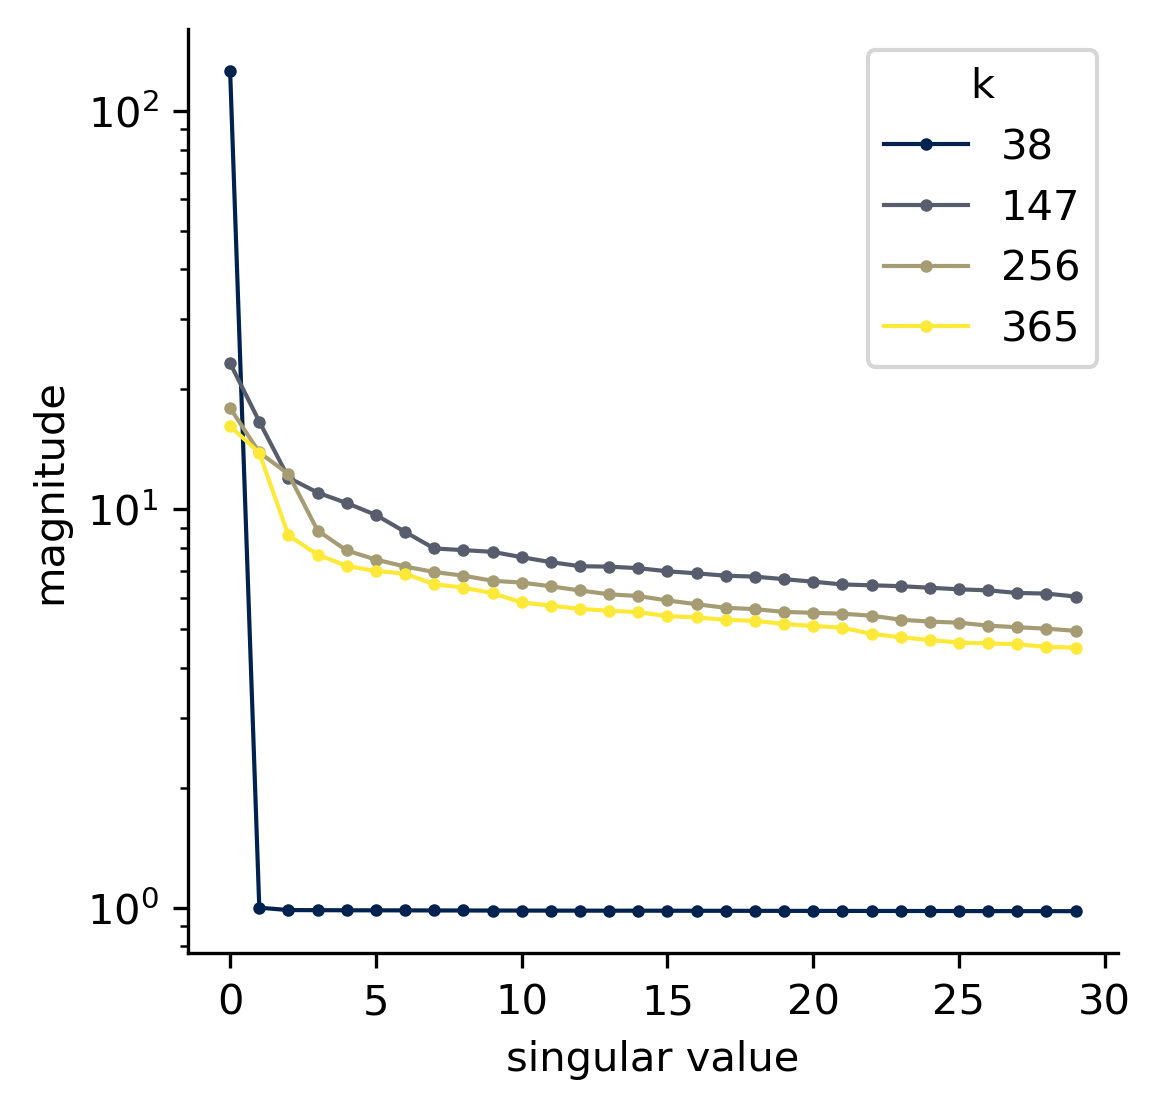

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sns.lineplot(
    data=result,
    x='index',
    y='magnitude',
    marker=".",
    hue='k',
    mec='none',
    lw=1,
    palette='cividis',
)

plt.ylabel('magnitude')
plt.xlabel('singular value')
plt.yscale('log')
sns.despine()

# Load membership matrix

In [7]:
k = 474
print(f"{k=}")

fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/hypergraph-mt/u_{k}.pkl"
df = pd.read_pickle(fpath)
print(f"{df.shape=}")
df.head()

k=474
df.shape=(17186, 474)


,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,group_10,...,group_465,group_466,group_467,group_468,group_469,group_470,group_471,group_472,group_473,group_474
Smarca2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Sh2d5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Dyrk1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.078138,0.0,0.0,0.0,0.0,0.0,0.0
Igf2bp3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Tmem267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


# Clustering?

In [8]:
""" SET UP AnnData """
var = pd.DataFrame(df.sum(axis=0), columns=['sum'])

obs = df.agg(['sum', 'mean', 'max', 'nonzero'], axis=1)
print(f"(raw) {obs.shape=}")
obs['n_groups'] = obs['nonzero'].apply(lambda x: len(x[0]))

obs = pd.merge(
    obs, nodes.set_index('gene_name'), how='left',
    left_index=True,
    right_index=True,
).reset_index(names='gene_name')
obs['log_expression'] = np.log1p(obs['expression'])
print(f"(filtered) {obs.shape=}")

# create anndata
adata = an.AnnData(
    X=csr_matrix(df.values), 
    obs=obs,
    var=var,
)

adata.layers['u'] = adata.X.copy()
adata

(raw) obs.shape=(17186, 4)
(filtered) obs.shape=(17186, 18)


AnnData object with n_obs × n_vars = 17186 × 474
    obs: 'gene_name', 'sum', 'mean', 'max', 'nonzero', 'n_groups', 'expression', 'is_tf', 'score', 'norm_score', 'is_core', 'bin_name', 'bin', 'chrom', 'n_genes', 'UMAP 1', 'UMAP 2', 'log_expression'
    var: 'sum'
    layers: 'u'

In [9]:
if 'leiden_colors' in adata.uns.keys():
    del adata.uns['leiden_colors']

print("Preprocessing...")
sc.pp.normalize_total(adata, target_sum=1)
sc.pp.pca(adata)

print("Computing nearest neighbors...")
sc.pp.neighbors(adata, n_neighbors=15,)

print("Running Leiden clustering...")
sc.tl.leiden(adata, resolution=0.20)
print(f"Detected {adata.obs['leiden'].nunique()} clusters.")

adata.obs['leiden'].value_counts()

Preprocessing...
Computing nearest neighbors...
Running Leiden clustering...


/tmp/ipykernel_4179134/314127484.py:12: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.20)


Detected 102 clusters.


leiden
0      5662
1       792
2       632
3       588
4       563
       ... 
97        8
98        8
99        7
100       7
101       7
Name: count, Length: 102, dtype: int64

In [10]:
adata

AnnData object with n_obs × n_vars = 17186 × 474
    obs: 'gene_name', 'sum', 'mean', 'max', 'nonzero', 'n_groups', 'expression', 'is_tf', 'score', 'norm_score', 'is_core', 'bin_name', 'bin', 'chrom', 'n_genes', 'UMAP 1', 'UMAP 2', 'log_expression', 'leiden'
    var: 'sum'
    uns: 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'u'
    obsp: 'distances', 'connectivities'

In [11]:
obsp_key = 'connectivities'
A = adata.obsp[obsp_key]
print(f"{A.shape=}")

G = nx.from_scipy_sparse_array(A)
print(G)

# get the initial positions using UMAP
rows = zip(range(len(adata)), adata.obs['UMAP 1'].values, adata.obs['UMAP 2'].values)
init_positions = {node_name: (umap1, umap2) for node_name, umap1, umap2 in rows}

pos = nx.spring_layout(
    G,
    pos=init_positions,
    k=0.001, # Increase this value to move nodes farther apart.
    seed=32,
    iterations=1,
)

positions = pd.DataFrame(
    pos, 
).T

positions.columns = ['U1', 'U2']
positions['gene_name'] = adata.obs['gene_name'].values

positions = pd.merge(
    positions, adata.obs.copy(), how='left',
)
print(f"{positions.shape=}")
positions.head()

A.shape=(17186, 17186)
Graph with 17186 nodes and 173447 edges
positions.shape=(17186, 21)


,U1,U2,gene_name,sum,mean,max,nonzero,n_groups,expression,is_tf,...,norm_score,is_core,bin_name,bin,chrom,n_genes,UMAP 1,UMAP 2,log_expression,leiden
0,-0.163951,-0.069348,Smarca2,0.093337,0.000197,0.093337,"([44],)",1,4.55,False,...,0.000022,False,chr19:265,24283,19,3,4.904234,-2.694967,1.713798,2
1,-0.248216,0.142266,Sh2d5,0.853784,0.001801,0.16364,"([130, 162, 266, 286, 385, 444, 457],)",7,1.89,False,...,0.003245,False,chr4:1379,6747,4,6,2.083629,3.465141,1.061257,2
2,-0.313855,0.696585,Dyrk1a,0.23436,0.000494,0.156222,"([168, 467],)",2,26.10,False,...,0.040631,False,chr16:943,22119,16,5,2.747340,14.155752,3.299534,0
3,0.175277,-0.145807,Igf2bp3,0.896754,0.001892,0.231444,"([59, 142, 216, 327, 365, 424],)",6,53.92,False,...,0.203218,False,chr6:491,8946,6,2,9.599099,-3.664884,4.005878,4
4,0.312261,-0.510758,Tmem267,0.08564,0.000181,0.08564,"([171],)",1,0.80,False,...,0.213183,False,chr13:1200,18874,13,3,14.101724,-9.536039,0.587787,27


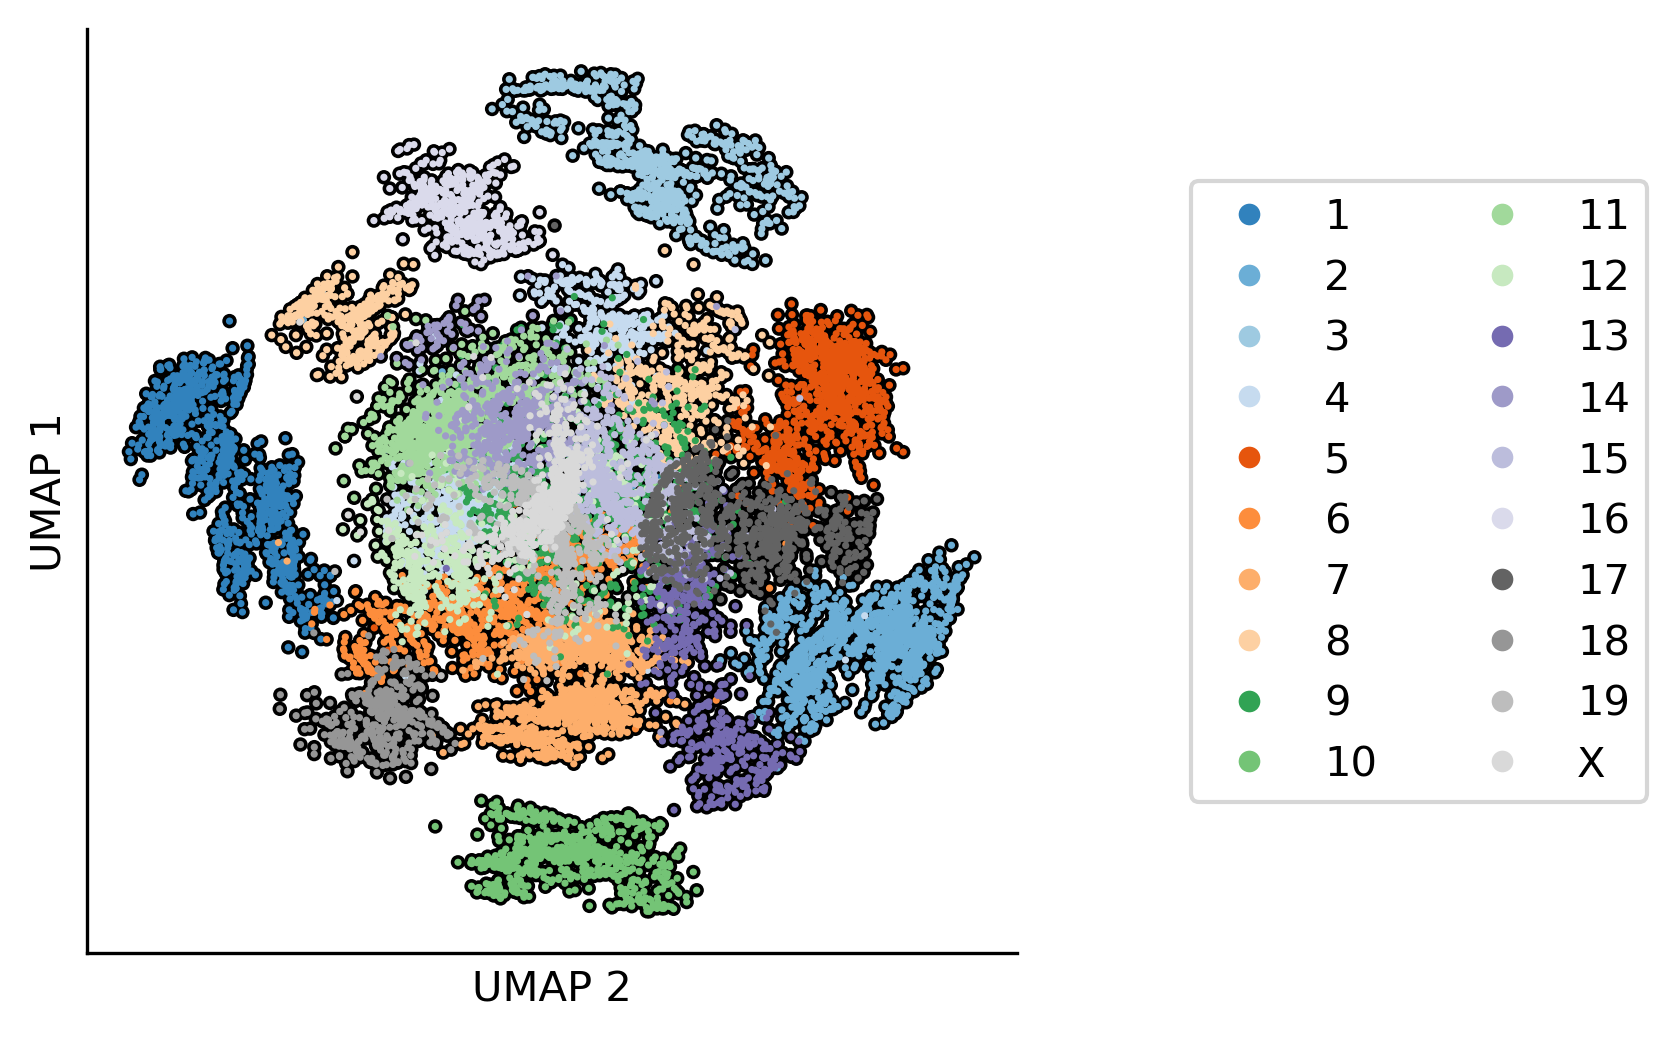

In [12]:
pdf = positions.copy()
pdf = pdf.sort_values(by='bin')

sns.scatterplot(
    data=pdf,
    x='U1',
    y='U2',
    c='k',
    s=12,
    ec='none',
    zorder=1,
)

sns.scatterplot(
    data=pdf,
    x='U1',
    y='U2',
    hue='chrom',
    s=3,
    ec='none',
    palette='tab20c',
    zorder=5,
)

plt.ylabel("UMAP 1")
plt.xlabel("UMAP 2")
plt.xticks([])
plt.yticks([])
sns.despine()
sns.move_legend(
    plt.gca(),
    title="",
    loc='center right',
    ncols=2,
    markerscale=3,
    bbox_to_anchor=(1.7, 0.5)
)

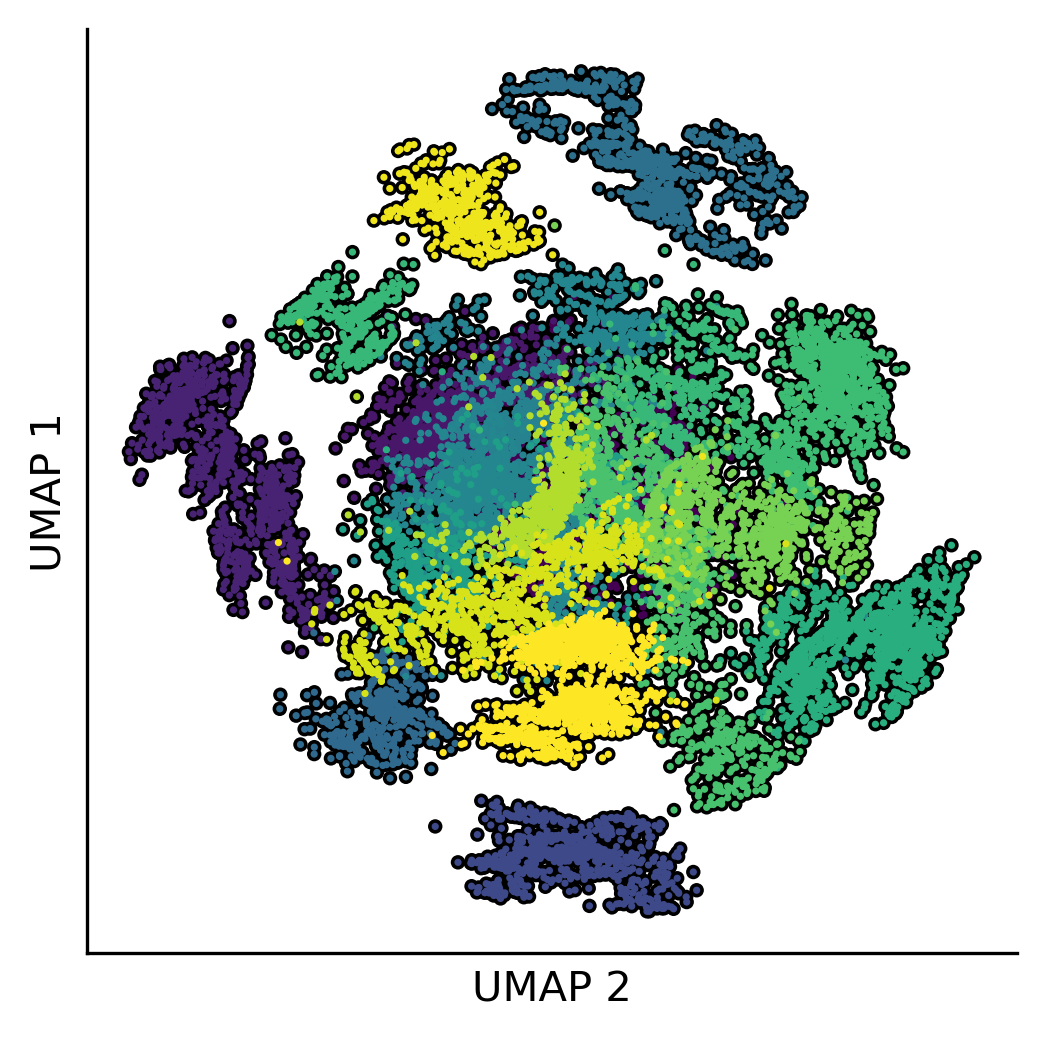

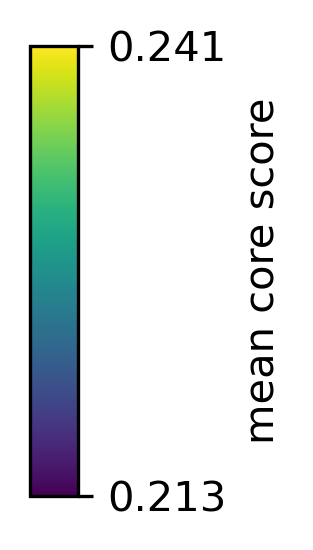

In [13]:
pdf = positions.copy()
pdf['chrom_core_score'] = pdf.groupby('chrom')['norm_score'].transform('mean')
pdf = pdf.sort_values(by='chrom_core_score')
cmap = 'viridis'

sns.scatterplot(
    data=pdf,
    x='U1',
    y='U2',
    c='k',
    s=12,
    ec='none',
    zorder=1,
)

sns.scatterplot(
    data=pdf,
    x='U1',
    y='U2',
    hue='chrom_core_score',
    s=3,
    ec='none',
    palette=cmap,
    zorder=5,
    legend=False,
)

plt.ylabel("UMAP 1")
plt.xlabel("UMAP 2")
plt.xticks([])
plt.yticks([])
sns.despine()
plt.show()

plt2.make_colorbar(
    cmap=cmap,
    title='mean core score', 
    tick_labels=[f"{pdf['chrom_core_score'].min():.3f}", 
                 f"{pdf['chrom_core_score'].max():.3f}"]
)

# Gene clustering

In [14]:
# Calculate the distance between each sample
Z = linkage(adata.to_df(), 'ward')
print(f"{Z.shape=}") 

Z.shape=(17185, 4)


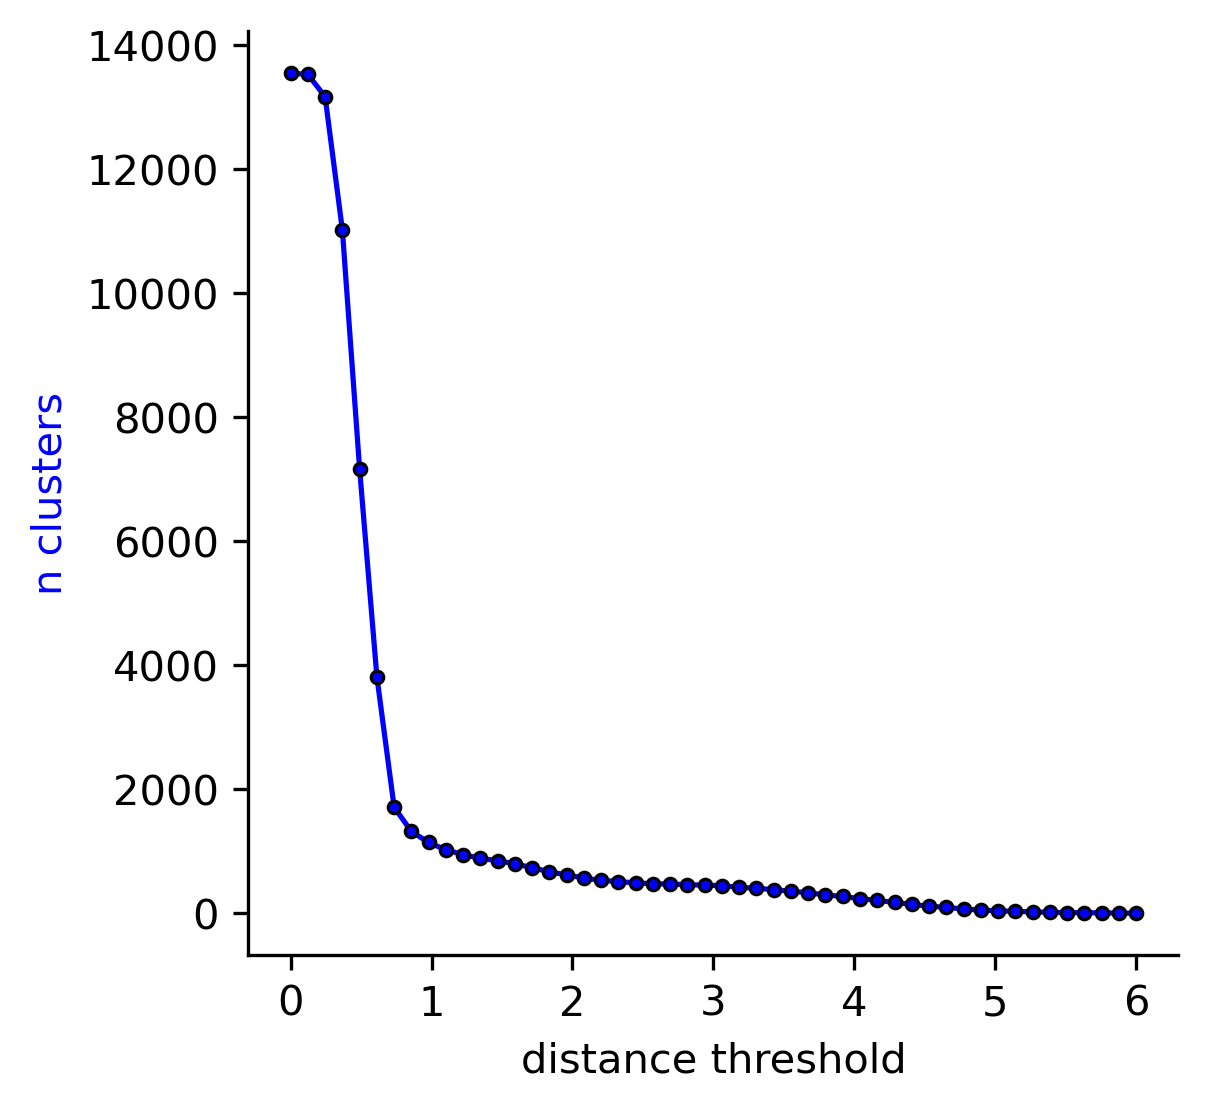

In [15]:
result = []
for t in np.linspace(0, 6):
    labels = fcluster(
        Z, 
        t=t, 
        criterion='distance',
    )
    n_cluster = len(set(labels))
    result.append({
        't' : t,
        'n_cluster' : n_cluster,
    })
    
result = pd.DataFrame(result)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sns.lineplot(
    data=result, 
    x='t',
    y='n_cluster',
    marker=".",
    color='b',
    mec='k',
    lw=1.25,
)
plt.ylabel('n clusters', c='b')
plt.xlabel('distance threshold')
sns.despine()

plt.gca().set_facecolor('none')

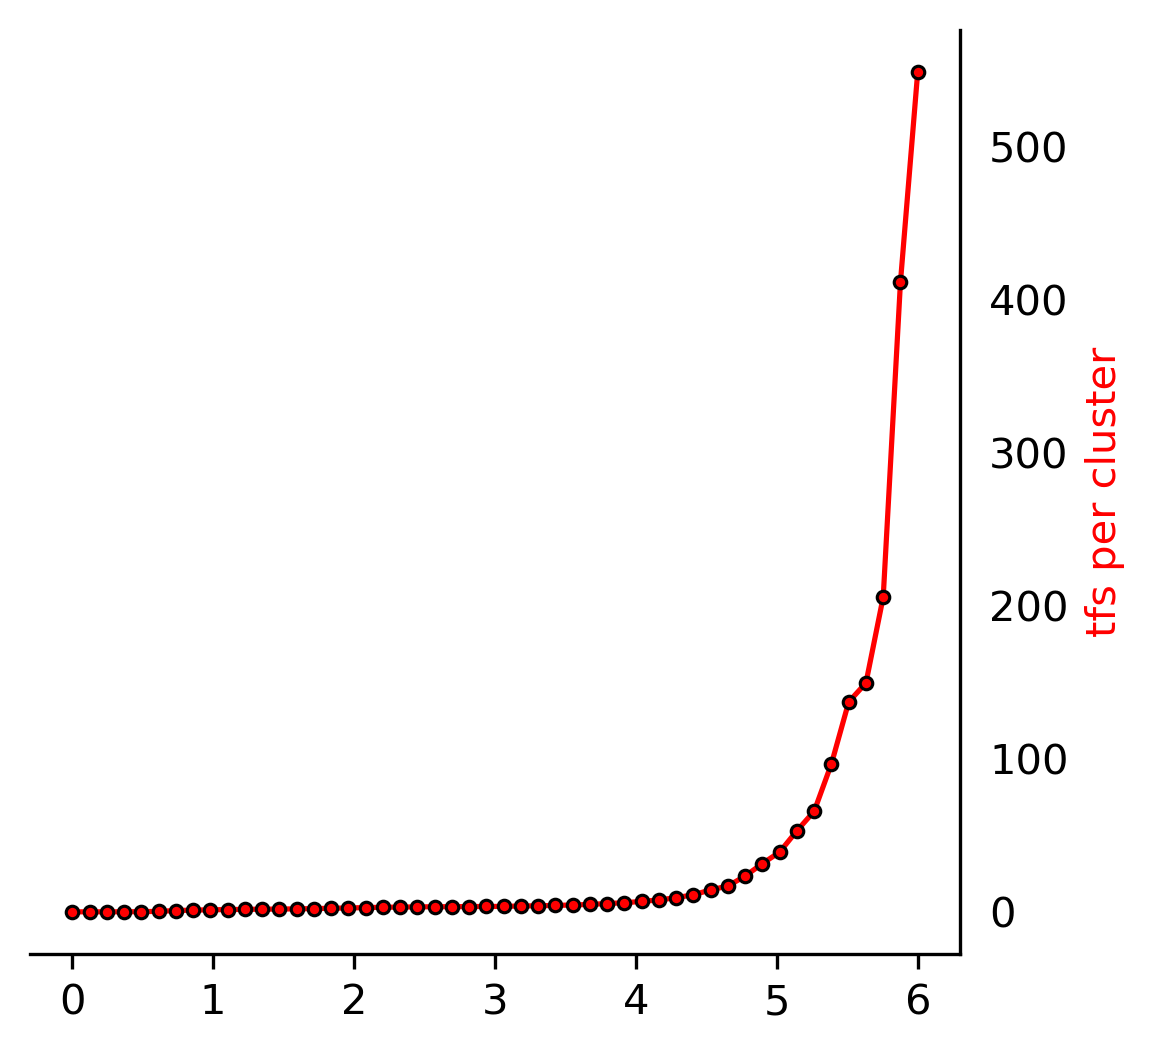

In [16]:
result = []
for t in np.linspace(0, 6):
    labels = fcluster(
        Z, 
        t=t, 
        criterion='distance',
    )
    obs = adata.obs.copy()
    obs['cluster'] = labels

    obs = obs.groupby('cluster').agg(
        n_gene = ('gene_name', 'count'),
        n_tf = ('is_tf', 'sum'),
        n_core = ('is_core', 'sum'),
    ).mean().to_dict()
    obs['t'] = t
    result.append(obs)

result = pd.DataFrame(result)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

plt.figure(facecolor='none') 

sns.lineplot(
    data=result, 
    x='t',
    y='n_tf',
    marker=".",
    c='r',
    mec='k',
    lw=1.25,
)

# Move the y-axis to the right
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()


plt.ylabel('tfs per cluster', c='r')
plt.xlabel('')
sns.despine(left=True, right=False)
plt.gca().set_facecolor('none')

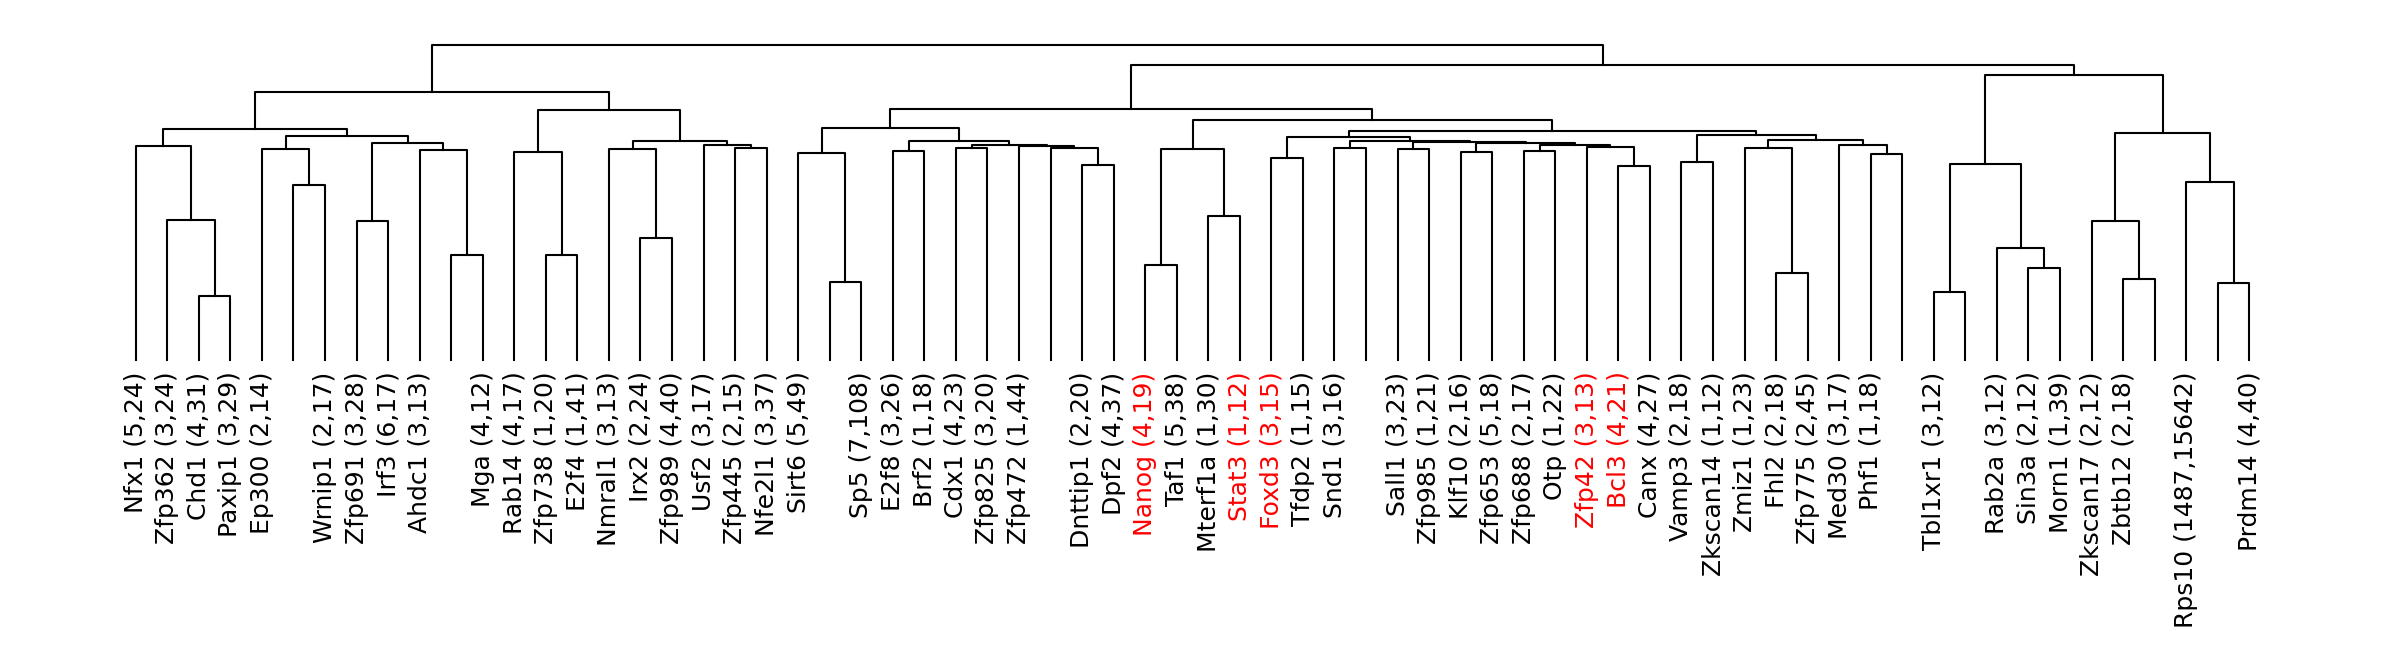

In [17]:
t = 4.8
adata.obs['labels'] = fcluster(
    Z, 
    t=t, 
    criterion='distance',
)

adata.obs['labels'] = adata.obs['labels'].astype('category')
tf_map = dict(zip(adata.obs['gene_name'].values, adata.obs['is_tf'].values))

# Find the most highly expressed gene per label
def get_top_gene(group):
    tfs = group[group['is_tf']]
    if tfs.empty:
        return ""
    else:
        idx = group[group['is_tf']]['expression'].idxmax()
        gene_name = group.loc[idx, 'gene_name']
        gene_name = f"{gene_name} ({len(tfs)},{len(group)})"
        return gene_name

top_genes = adata.obs.groupby('labels').apply(get_top_gene)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 1.5

# Annotate the dendrogram
sc.tl.dendrogram(adata, 'labels')
ax = sc.pl.dendrogram(
    adata,
    'labels', 
    remove_labels=False,
    show=False,
)  

# Access and modify all lines in the axes
for line in ax.lines:
    # Example modifications:
    line.set_color('k') 
    line.set_linewidth(0.5)  # Change linewidth

# Get the x-tick positions and labels
x_tick_positions = ax.get_xticks()
x_tick_labels = ax.get_xticklabels()

# Add annotations for top genes
for x_pos, label in zip(x_tick_positions, x_tick_labels):
    cluster_id = int(label.get_text())  # Get cluster ID from label
    top_gene = top_genes.loc[cluster_id]
    color = 'k'
    if top_gene == '':
        continue
    if top_gene.split(" ")[0] in stem_genes:
        color = 'r'
    ax.text(
        x_pos,
        -0.05, 
        top_gene, 
        c=color,
        rotation=90,
        ha='center', 
        va='top',
        fontsize=6,
    )

_ = ax.set_xticklabels([])

In [18]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# enrichment

In [62]:
top_genes.sample(5).to_list()

['Irf3 (6,17)', 'Morn1 (1,39)', 'Snd1 (3,16)', 'Wrnip1 (2,17)', 'Sall1 (3,23)']

In [68]:
database = 'ontology'
alpha = 0.05
tpm_threshold = 2.0

# query = top_genes.sample(5).to_list()
query = [
    'Zfp653 (5,18)',
    'Mga (4,12)',
    'Bcl3 (4,21)',
    'E2f4 (1,41)',
    'Phf1 (1,18)',
    'Nmral1 (3,13)',
    'Nanog (4,19)',
    'Prdm14 (4,40)',
]

query_clusters = top_genes[top_genes.isin(query)]
obs = adata.obs.copy()

for cluster, label in query_clusters.items():
    time.sleep(2)
    group = obs[obs['labels'] == cluster]
    group = group[group['expression'] > tpm_threshold]
    
    print(f"\n---- {label} (n={len(group)} expressed) (cluster id: {cluster}) ----")
    edf = gget.enrichr(group['gene_name'].to_list(), database=database)
    edf['is_sig'] = edf['adj_p_val'] <= alpha

    for idx, row in edf.head(5).iterrows():
        pathname = row['path_name'].split(' (')[0]
        overlapping = row['overlapping_genes']
        if not len(overlapping) > 1:
            continue
        genes = ",".join(overlapping)
        print(f"\t{row['is_sig']} {pathname}: ({len(overlapping)}) {genes}")

Tue Jan 14 17:50:54 2025 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



---- Phf1 (1,18) (n=14 expressed) (cluster id: 14) ----
	True negative regulation of ubiquitin-dependent protein catabolic process: (2) PDCL3,N4BP1
	False chromatin organization: (2) INO80C,PHF1


Tue Jan 14 17:50:56 2025 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



---- Bcl3 (4,21) (n=15 expressed) (cluster id: 15) ----
	True response to ketone: (3) TGFB1,ABHD2,SLIT2
	True cell surface receptor signaling pathway involved in heart development: (2) TGFB1,RBPJ
	True response to progesterone: (2) TGFB1,ABHD2
	True response to alcohol: (2) TGFB1,SLIT2
	True aortic valve morphogenesis: (2) TGFB1,SLIT2


Tue Jan 14 17:50:58 2025 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



---- Nmral1 (3,13) (n=8 expressed) (cluster id: 32) ----
	True regulation of RNA splicing: (2) AHNAK,ZPR1
	True positive regulation of intracellular protein transport: (2) UBE2D3,ZPR1


Tue Jan 14 17:51:01 2025 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



---- Mga (4,12) (n=7 expressed) (cluster id: 46) ----
	True negative regulation of cell cycle process: (2) BMP4,MGA
	True positive regulation of developmental process: (2) BMP4,SHLD2


Tue Jan 14 17:51:03 2025 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



---- Nanog (4,19) (n=9 expressed) (cluster id: 52) ----
	True negative regulation of cytoskeleton organization: (2) SMAD4,CYRIB
	True negative regulation of supramolecular fiber organization: (2) SMAD4,CYRIB
	True positive regulation of protein serine/threonine kinase activity: (2) IL34,TELO2
	True positive regulation of protein kinase activity: (2) IL34,TELO2
	True cytokine-mediated signaling pathway: (3) SMAD4,IL34,NANOG


Tue Jan 14 17:51:05 2025 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



---- Prdm14 (4,40) (n=24 expressed) (cluster id: 55) ----
	False organophosphate biosynthetic process: (2) MOCS2,IP6K2
	False glycosphingolipid metabolic process: (2) CPTP,ST3GAL5
	False polyol metabolic process: (2) PLCB4,IP6K2
	False inositol phosphate metabolic process: (2) PLCB4,IP6K2
	False chromatin remodeling: (2) SMARCD1,BAZ1A


Tue Jan 14 17:51:08 2025 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



---- E2f4 (1,41) (n=19 expressed) (cluster id: 62) ----
	True regulation of Golgi to plasma membrane protein transport: (2) CLN3,CSK
	True organelle transport along microtubule: (2) CLN3,COPG2


Tue Jan 14 17:51:10 2025 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



---- Zfp653 (5,18) (n=14 expressed) (cluster id: 67) ----
	True DNA duplex unwinding: (2) PIF1,MCM2
	True double-strand break repair via homologous recombination: (2) RFWD3,MCM2
	True DNA replication: (2) PIF1,MCM2


In [ ]:
# ?sc.tl.dendrogram

In [ ]:
pdf = positions.copy()
t = 1
pdf['labels'] = fcluster(
    Z, 
    t=t, 
    criterion='distance',
)


In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 4.5

threshold = 4

labels = np.where(adata.obs['is_tf'], adata.obs['gene_name'], "")

cluster_assignments = fcluster(Z, t=threshold, criterion='distance')

dendrogram(
    Z, 
    truncate_mode="level", 
    p=threshold,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=8,
    above_threshold_color='k',
)

plt.xlabel("")
plt.ylabel("distance")
sns.despine()
plt.show()


In [ ]:
?dendrogram

In [ ]:
# t = 5.5

# pdf = positions.copy()
# pdf['labels'] = fcluster(
#     Z, 
#     t=t, 
#     criterion='distance',
# )

# print(pdf['labels'].value_counts())


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 4, 4

# sns.scatterplot(
#     data=pdf,
#     x="U1",
#     y="U2",
#     hue='labels',
# )



In [ ]:
# sc.pl.clustermap(
#     adata, 
#     obs_keys='chrom',
# )

In [ ]:
# Calculate the distance between each sample
Z = linkage(adata.to_df(), 'ward')
print(f"{Z.shape=}") 

In [ ]:

# Step 4: Plot the dendrogram
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 3

labels = np.where(adata.obs['is_tf'], adata.obs['gene_name'], "")

dendrogram(
    Z, 
    truncate_mode="level", 
    p=35,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=8,
)

plt.xlabel("")
plt.ylabel("distance")
# plt.yscale('log') 
sns.despine()
plt.show()

In [ ]:
break

In [ ]:
# # The `children_` attribute provides the linkage tree
# linkage_matrix = np.column_stack([
#     model.children_, 
#     model.distances_, 
#     np.zeros(model.children_.shape[0]) + 2
# ])

# print(f"{linkage_matrix.shape=}")

# cluster_labels = {}

# for t in range(1, 7):
#     labels = fcluster(
#         linkage_matrix, 
#         t=t, 
#         criterion='distance',
#     )

#     cluster_labels[f"level_{t}"] = labels
#     print(f"at level {t}, {len(set(labels))} labels")
    
# cluster_labels = pd.DataFrame(
#     cluster_labels, 
# )
# cluster_labels['gene_name'] = adata.obs['gene_name'].values
# cluster_labels.head()

In [ ]:
def create_linkage_matrix(model):
    n_samples = model.n_leaves_
    counts = np.zeros(model.children_.shape[0])
    for i, (left_child, right_child) in enumerate(model.children_):
        count = 0
        if left_child < n_samples:
            count += 1  # A single data point
        else:
            count += counts[left_child - n_samples]
        if right_child < n_samples:
            count += 1
        else:
            count += counts[right_child - n_samples]
        counts[i] = count
    # Linkage matrix
    linkage_matrix = np.column_stack([
        model.children_,    # Merged clusters
        model.distances_,   # Distances
        counts              # Number of samples in each cluster
    ])
    return linkage_matrix

linkage_matrix = create_linkage_matrix(model)
print(f"{linkage_matrix.shape=}")

labels = np.where(adata.obs['is_tf'], adata.obs['gene_name'], "")

# Step 4: Plot the dendrogram
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 3


dendrogram(
    linkage_matrix, 
    truncate_mode="level", 
    p=55,
    labels=labels,
    above_threshold_color='k',
)

plt.xlabel("")
plt.ylabel("distance")
sns.despine()
plt.show()

In [ ]:
dendrogram(
    linkage_matrix,
    truncate_mode="level",
    p=25,
    labels=adata.obs['gene_name'].values,
    above_threshold_color='k',
    show_leaf_counts=False,  # Remove leaf counts for cleaner look
    orientation='top',       # Orient dendrogram from the top down
    leaf_rotation=90.,     # Rotate leaf labels for readability
    leaf_font_size=6.,     # Adjust leaf font size as needed
)


In [ ]:
?dendrogram

In [ ]:
?dendrogram

In [ ]:
pos

In [ ]:
print("Computing UMAP embedding...")
sc.tl.umap(
    adata,
    alpha=0.01,
    min_dist=0.9,
    maxiter=10,
    init_pos=adata.obs[['UMAP 1', 'UMAP 2']].to_numpy(),
)

print("Generating UMAP plot...")
sc.pl.umap(
    adata,
    color=["leiden", 'chrom'],
    ncols=1,
)

In [ ]:
break

In [ ]:
break